In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
%matplotlib inline

In [2]:
shelterDf = pd.read_csv('Austin_Animal_Center_Outcomes.csv')

In [3]:
shelterDf.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A682730,Freddy,03/19/2019 06:54:00 PM,03/19/2019 06:54:00 PM,07/04/2013,Return to Owner,NaN,Dog,Neutered Male,5 years,Pit Bull Mix,Fawn
1,A790982,Blue,03/19/2019 06:54:00 PM,03/19/2019 06:54:00 PM,12/19/2017,Return to Owner,NaN,Dog,Intact Male,1 year,Pit Bull Mix,Blue/White
2,A790653,*O'Brian,03/19/2019 06:35:00 PM,03/19/2019 06:35:00 PM,09/13/2017,Adoption,NaN,Dog,Spayed Female,1 year,Pembroke Welsh Corgi Mix,Red/White
3,A475011,Tobie,03/19/2019 06:14:00 PM,03/19/2019 06:14:00 PM,05/11/2006,Return to Owner,NaN,Dog,Intact Male,12 years,German Shepherd Mix,Black/White
4,A790581,Mia,03/19/2019 06:11:00 PM,03/19/2019 06:11:00 PM,03/12/2018,Adoption,NaN,Dog,Spayed Female,1 year,Pit Bull Mix,Black/White


In [4]:
shelterDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97101 entries, 0 to 97100
Data columns (total 12 columns):
Animal ID           97101 non-null object
Name                67197 non-null object
DateTime            97101 non-null object
MonthYear           97101 non-null object
Date of Birth       97101 non-null object
Outcome Type        97093 non-null object
Outcome Subtype     43953 non-null object
Animal Type         97101 non-null object
Sex upon Outcome    97099 non-null object
Age upon Outcome    97093 non-null object
Breed               97101 non-null object
Color               97101 non-null object
dtypes: object(12)
memory usage: 8.9+ MB


In [5]:
shelterDf.nunique()

Animal ID           87157
Name                16563
DateTime            80244
MonthYear           80244
Date of Birth        6371
Outcome Type            9
Outcome Subtype        20
Animal Type             5
Sex upon Outcome        5
Age upon Outcome       49
Breed                2372
Color                 567
dtype: int64

In [6]:
shelterDf['Animal Type'].value_counts()

Dog          55508
Cat          35964
Other         5165
Bird           452
Livestock       12
Name: Animal Type, dtype: int64

We're going to focus on cats and dogs

**Clean Data**

There is a lot of subjectivity in determining an animals breed and color e.g. many of the colors/breeds have only one animal assigned to that type. Therefore, we are only going to be looking at the top 10 breeds and drop the color feature

In [7]:
print('--Breeds--')
print(shelterDf['Breed'].value_counts().tail(10))
print('--Colors--')
print(shelterDf['Color'].value_counts().tail(10))

--Breeds--
Miniature Poodle/English Cocker Spaniel    1
Labrador Retriever/English Bulldog         1
Chinese Sharpei/Black Mouth Cur            1
English Coonhound/Italian Greyhound        1
Great Pyrenees/Rat Terrier                 1
Catahoula/Jack Russell Terrier             1
Angora-Satin Mix                           1
Norfolk Terrier/Bruss Griffon              1
Wire Hair Fox Terrier/German Shepherd      1
Burmese Mix                                1
Name: Breed, dtype: int64
--Colors--
Brown Tabby/Black Brindle    1
White/Flame Point            1
Black Brindle/Blue Tick      1
Black Smoke/Brown Tabby      1
Tricolor/Calico              1
Cream/Cream                  1
Agouti/Cream                 1
Calico/Calico                1
Gray/Blue Merle              1
Yellow/Red                   1
Name: Color, dtype: int64


In [8]:
shelterDf = shelterDf[shelterDf.groupby('Breed').Breed.transform(len) > 1000]
print('Number of Breeds: ' + str(shelterDf['Breed'].nunique()))
print('Number of Animals: ' + str(shelterDf['Breed'].count()))

Number of Breeds: 10
Number of Animals: 58935


In [9]:
print(shelterDf[shelterDf['Animal Type'] == 'Other']['Breed'].value_counts())
print(shelterDf[shelterDf['Animal Type'] == 'Other']['Outcome Type'].value_counts())

Bat Mix    1680
Name: Breed, dtype: int64
Euthanasia    1464
Disposal       169
Died            44
Name: Outcome Type, dtype: int64


The animals in the 'other' category are all bats and I highly doubt bats are up for adoption. They will be dropped from the data set

In [10]:
shelterDf = shelterDf[shelterDf['Animal Type'] != 'Other']

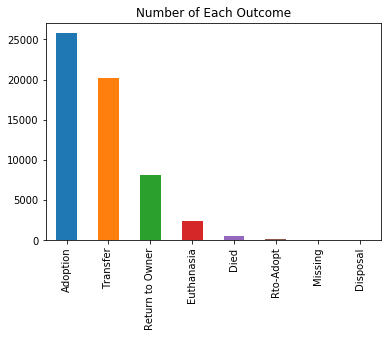

In [11]:
shelterDf['Outcome Type'].value_counts().plot(kind = 'bar', title = 'Number of Each Outcome')
plt.show()

Seems to be a pretty effective shelter although transfer doesn't mean adopted rather they were trasfered to another facility 

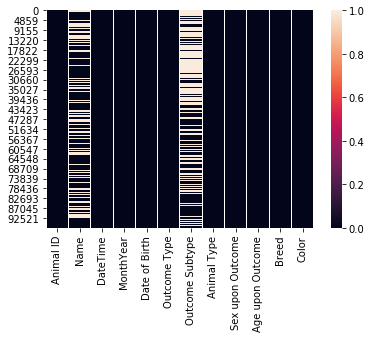

In [12]:
sns.heatmap(shelterDf.isnull())
plt.show()

In [13]:
shelterDf.isnull().sum()

Animal ID               0
Name                19061
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            3
Outcome Subtype     28595
Animal Type             0
Sex upon Outcome        1
Age upon Outcome        4
Breed                   0
Color                   0
dtype: int64

Will be best to just drop Name and Outcome Subtype (will drop later)

In [14]:
# Add feature 'Was Adopted', 1 is adopted, 0 not adopted
shelterDf['Was Adopted'] = shelterDf['Outcome Type'].apply(lambda x: 1 if x == 'Adoption' else 0)

In [15]:
# If the 'name' column has a float then its NaN
shelterDf['Has Name'] = shelterDf['Name'].apply(lambda x: 1 if not isinstance(x, float) else 0)

In [16]:
# Make 'datetime' and 'date_of_birth' datetime objects
# There is several typos in Date of Birth so we'll drop those
shelterDf['DateTime'] = shelterDf['DateTime'].apply(lambda x: datetime.datetime.strptime(x[0:-3], '%m/%d/%Y %H:%M:%S'))
shelterDf['Date of Birth'] = shelterDf['Date of Birth'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))

In [17]:
# Make 'month' and 'year' features
shelterDf['Month'] = shelterDf['DateTime'].apply(lambda x: x.month)
shelterDf['Year'] = shelterDf['DateTime'].apply(lambda x: x.year)

In [18]:
# Change 'age upon outcome' to days for cosistency
shelterDf['Age upon Outcome'] = shelterDf['DateTime'] - shelterDf['Date of Birth']
daysRegex = re.compile('\d+')
shelterDf['Age upon Outcome'] = shelterDf['Age upon Outcome'].apply(lambda x: round(int(daysRegex.search(str(x)).group())))

In [19]:
# Data starts in 2013 and is incomplete
shelterDf['Year'].value_counts()

2015    11034
2016    10877
2017    10726
2014    10425
2018     9913
2013     2554
2019     1726
Name: Year, dtype: int64

They started data collection in 2013 and its only March 2019 currently, so its expected to have much less animals in those years

*Drop any columns that are no longer needed*

In [20]:
# Drop Name and Outcome Subtype: too many NaN
# Drop MonthYear: redundant
# Drop Color
# Drop Animal ID
# Drop DateTime
# Drop Date of Birth
shelterDf.drop(['Date of Birth','DateTime', 'Name', 'Outcome Subtype', 'Outcome Type', 'MonthYear', 'Color', 'Animal ID'], axis = 1, inplace = True)
shelterDf.dropna(inplace = True)

In [21]:
shelterDf.isnull().sum()

Animal Type         0
Sex upon Outcome    0
Age upon Outcome    0
Breed               0
Was Adopted         0
Has Name            0
Month               0
Year                0
dtype: int64

In [22]:
shelterDf.reset_index(inplace=True, drop=True)
shelterDf.head(3)

,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Was Adopted,Has Name,Month,Year
0,Dog,Neutered Male,2084,Pit Bull Mix,0,1,3,2019
1,Dog,Intact Male,455,Pit Bull Mix,0,1,3,2019
2,Dog,Intact Male,4695,German Shepherd Mix,0,1,3,2019


In [23]:
shelterDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57254 entries, 0 to 57253
Data columns (total 8 columns):
Animal Type         57254 non-null object
Sex upon Outcome    57254 non-null object
Age upon Outcome    57254 non-null int64
Breed               57254 non-null object
Was Adopted         57254 non-null int64
Has Name            57254 non-null int64
Month               57254 non-null int64
Year                57254 non-null int64
dtypes: int64(5), object(3)
memory usage: 3.5+ MB


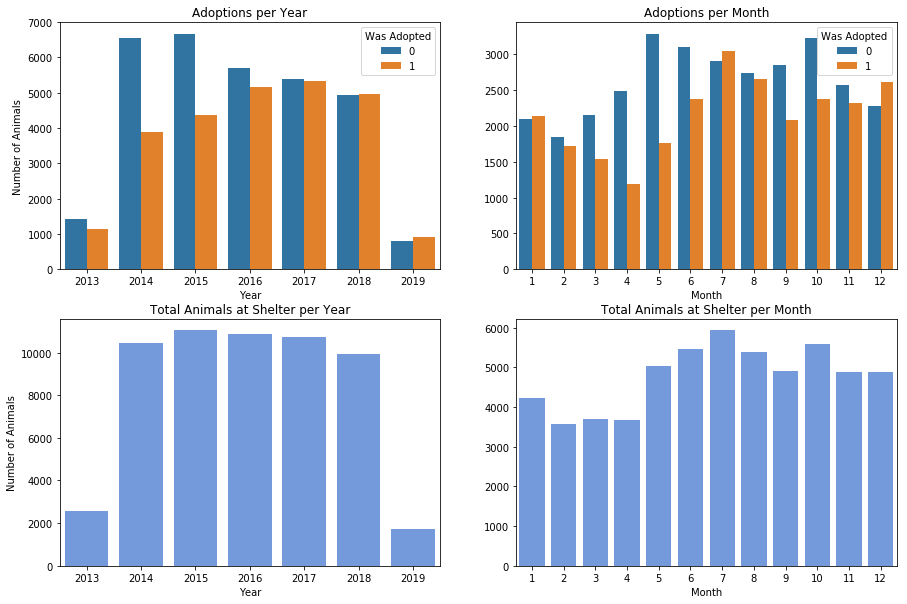

In [24]:
# Graphs of adoptions per year and per month
fig, axes = plt.subplots(figsize = (15,10), ncols =2, nrows = 2)
sns.countplot(shelterDf['Year'], hue = shelterDf['Was Adopted'], ax = axes[0,0]).set_title('Adoptions per Year')
sns.countplot(shelterDf['Month'],hue = shelterDf['Was Adopted'], ax = axes[0,1]).set_title('Adoptions per Month')
sns.countplot(shelterDf['Year'], ax = axes[1,0], color = 'cornflowerblue').set_title('Total Animals at Shelter per Year')
sns.countplot(shelterDf['Month'], ax = axes[1,1], color = 'cornflowerblue').set_title('Total Animals at Shelter per Month')

axes[0,0].set_ylabel('Number of Animals')
axes[1,0].set_ylabel('Number of Animals')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')
plt.show()

There appears to be a slight increase in adoptions from 2014 to 2018 while the total number of animals remains the same.
Adoptions in early months are significantly less than in later months but there are also less animals in the shelter in total. This makes sense since the increase in adoption at the end of the year will result in people not needing a pet and less animals in the shelter

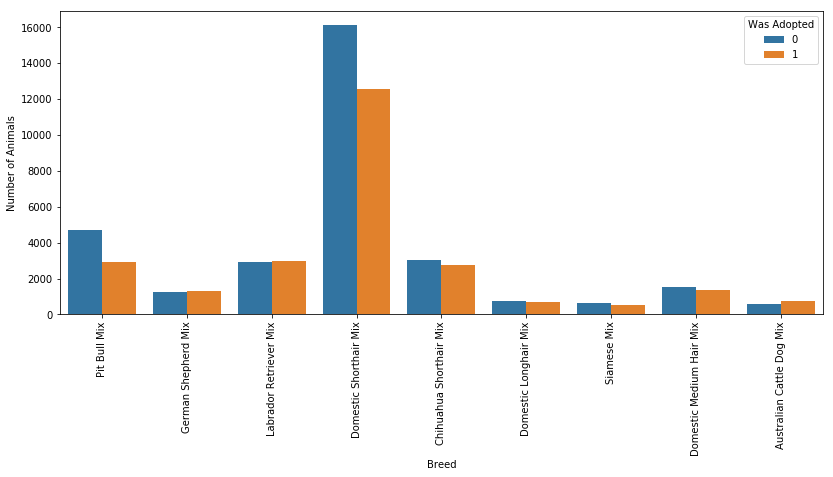

In [25]:
plt.figure(figsize= (12,5))
sns.countplot(x = 'Breed', data = shelterDf, hue = 'Was Adopted')
plt.tight_layout()
plt.xticks(rotation = 90)
plt.ylabel('Number of Animals')
plt.show()

It wouldn't seem that breed has much impact on whether an animal get adopted either and should be dropped during pre-processing. 'Domestic Shorthair Mix' is the most common breed. I assume that is because its difficult to classify cats any further than 'Short hair', 'Long hair', etc.

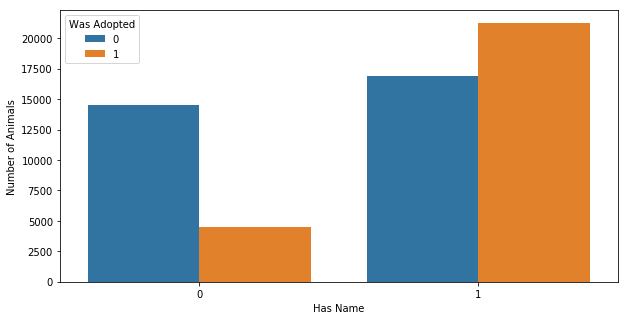

In [26]:
plt.figure(figsize= (10,5))
df = shelterDf.sample(frac = 0.01).reset_index(drop=True)

sns.countplot(shelterDf['Has Name'], hue = shelterDf['Was Adopted']).set_ylabel('Number of Animals')
plt.show()

It is clear that animals with names were much more likely to get adopted. This could be because a named animal is more likely to be well behaved and healthy, since it would likely have come from a home rather than the streets. However, there could also be cases were the shelter names found animals themselves. 

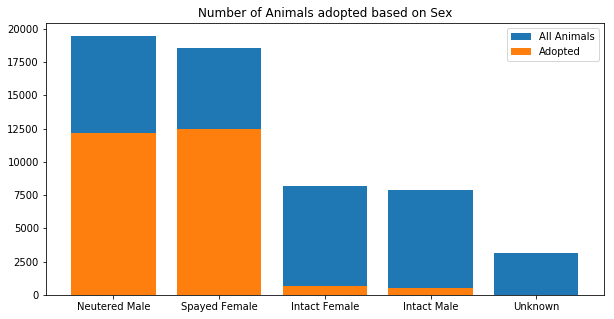

In [27]:
# Sex of adopted and not adopted animals
adopted = dict(shelterDf[shelterDf['Was Adopted'] == 1]['Sex upon Outcome'].value_counts())
allAni = dict(shelterDf['Sex upon Outcome'].value_counts())
plt.figure(figsize = (10,5))
plt.bar(allAni.keys(), allAni.values(), label = 'All Animals')
plt.bar(adopted.keys(), adopted.values(), label = 'Adopted')
plt.title('Number of Animals adopted based on Sex')
plt.legend()
plt.show()

Of the animals adopted, none were of the 'unknown sex upon outcome' and very few were still 'Intact' males or females. The  conditions that would be required to make an animals sex unknown (unclean, sick, injured, etc) would make them undesirable for adoption.

It would seem that if an animal is spayed or neutered will be a strong predictor of adoption.

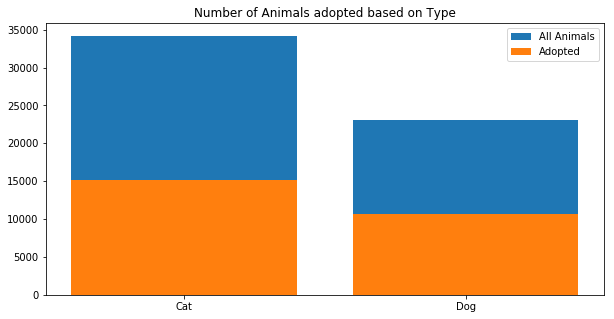

In [28]:
adopted = dict(shelterDf[shelterDf['Was Adopted'] == 1]['Animal Type'].value_counts())
allAni = dict(shelterDf['Animal Type'].value_counts())
plt.figure(figsize = (10,5))
plt.bar(allAni.keys(), allAni.values(), label = 'All Animals')
plt.bar(adopted.keys(), adopted.values(), label = 'Adopted')
plt.title('Number of Animals adopted based on Type')
plt.legend()
plt.show()

The adoption of dogs and cats seems to be very similar based on the total number of cats and dogs e.g. ~50% of the cats and dogs at the shelter were adopted



C:\Users\TinyPoots\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


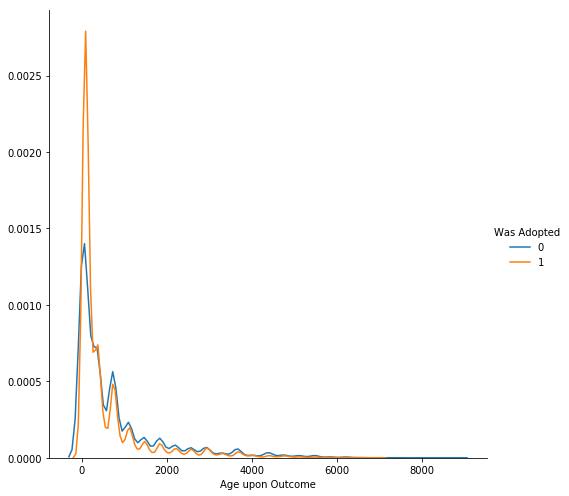

In [29]:
f = sns.FacetGrid(shelterDf, hue="Was Adopted", height=7)
f.map(sns.kdeplot, "Age upon Outcome") 
f.add_legend()
plt.show()

Clear that majority of adoptions and outcomes in general happen when the animals are young. There is a peak at about the 2 year mark (730 days). This could be due to the shelter having an age limit when an animals needs to be adopted, transfered, etc. This will likely be a strong predictor for the later models.

**Preproccessing for machine learning**

Based on the previous graphs 'Year', 'Breed', and 'Animal Type' dont seem to have a significant impact on whether an animal will be adopted so they will be dropped.

In [30]:
shelterDf.drop(['Animal Type', 'Year', 'Breed'], axis = 1, inplace = True)

'Sex upon outcome' needs to be encoded to dummy variables to be used by a machine learning model

In [31]:
nominalFeatures = ['Sex upon Outcome']
dummyDf = pd.get_dummies(shelterDf[nominalFeatures],drop_first=True)
shelterDf = pd.concat([shelterDf, dummyDf], axis=1)
shelterDf.drop(nominalFeatures, axis = 1, inplace = True)

In [32]:
shelterDf.head(3)

,Age upon Outcome,Was Adopted,Has Name,Month,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown
0,2084,0,1,3,0,1,0,0
1,455,0,1,3,1,0,0,0
2,4695,0,1,3,1,0,0,0


In [33]:
shelterDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57254 entries, 0 to 57253
Data columns (total 8 columns):
Age upon Outcome                  57254 non-null int64
Was Adopted                       57254 non-null int64
Has Name                          57254 non-null int64
Month                             57254 non-null int64
Sex upon Outcome_Intact Male      57254 non-null uint8
Sex upon Outcome_Neutered Male    57254 non-null uint8
Sex upon Outcome_Spayed Female    57254 non-null uint8
Sex upon Outcome_Unknown          57254 non-null uint8
dtypes: int64(4), uint8(4)
memory usage: 2.0 MB


Standardize values of 'Month' and 'Age upon Outcome'

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()

In [36]:
shelterDf['Age upon Outcome'] = scaler.fit_transform(shelterDf['Age upon Outcome'].values.reshape(-1,1))

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [37]:
shelterDf['Month'] = scaler.fit_transform(shelterDf['Month'].values.reshape(-1,1))

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


**Logistical Regression**

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X = shelterDf.drop(['Was Adopted'], axis =1)
y = shelterDf['Was Adopted']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
logModel = LogisticRegression()

In [43]:
logModel.fit(X_train, y_train)

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
predictions = logModel.predict(X_test)

In [45]:
from sklearn.metrics import classification_report,confusion_matrix

In [46]:
logClass = classification_report(y_test, predictions)
logConf = confusion_matrix(y_test, predictions)

print(logClass)
print(logConf)

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      9535
           1       0.69      0.87      0.77      7642

   micro avg       0.77      0.77      0.77     17177
   macro avg       0.78      0.78      0.77     17177
weighted avg       0.79      0.77      0.77     17177

[[6568 2967]
 [ 978 6664]]


Logistic regression yielded fairly accurate predictions with an average precision of about 0.80

**Support Vector Classification**

In [47]:
from sklearn.svm import SVC

In [48]:
SVCmodel = SVC()

In [49]:
SVCmodel.fit(X_train, y_train)

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [50]:
predictions = SVCmodel.predict(X_test)

In [51]:
svcClass = classification_report(y_test, predictions)
svcConf = confusion_matrix(y_test, predictions)
print(svcClass)
print(svcConf)

              precision    recall  f1-score   support

           0       0.83      0.76      0.80      9535
           1       0.73      0.81      0.77      7642

   micro avg       0.78      0.78      0.78     17177
   macro avg       0.78      0.79      0.78     17177
weighted avg       0.79      0.78      0.78     17177

[[7263 2272]
 [1448 6194]]


Similar results to logistical regression.

**Random Forest Classification**

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
randomForest = RandomForestClassifier().fit(X_train, y_train)

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [54]:
predictions = randomForest.predict(X_test)

In [55]:
forestClass = classification_report(y_test, predictions)
forestConf = confusion_matrix(y_test, predictions)

print(forestClass)
print(forestConf)

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      9535
           1       0.75      0.76      0.76      7642

   micro avg       0.78      0.78      0.78     17177
   macro avg       0.78      0.78      0.78     17177
weighted avg       0.78      0.78      0.78     17177

[[7625 1910]
 [1838 5804]]


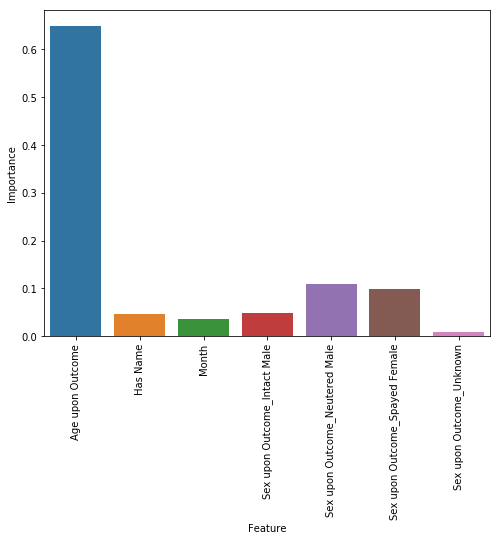

In [56]:
importantFeatures = pd.DataFrame({'Feature':shelterDf.drop(['Was Adopted'], axis = 1).columns,'Importance':randomForest.feature_importances_.tolist()})

plt.figure(figsize=(8, 6))
f = sns.barplot(data=importantFeatures, x='Feature', y='Importance')
plt.xticks(rotation=90)
plt.show()

The predictions are on par with the other two alrogithms. Also it can be seen that 'Age upon Outcome' is very important for the Random Forsest. I want to look at how well the Random Forest can do with just the 'Age upon Outcome' feature.

In [57]:
X = shelterDf['Age upon Outcome'].values.reshape(-1,1)
y = shelterDf['Was Adopted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [58]:
randomForest = RandomForestClassifier().fit(X_train, y_train)

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [59]:
predictions = randomForest.predict(X_test)

In [60]:
forestClass = classification_report(y_test, predictions)
forestConf = confusion_matrix(y_test, predictions)

print(forestClass)
print(forestConf)

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      9459
           1       0.68      0.75      0.71      7718

   micro avg       0.73      0.73      0.73     17177
   macro avg       0.73      0.73      0.73     17177
weighted avg       0.73      0.73      0.73     17177

[[6708 2751]
 [1903 5815]]


There is definitely a decrease in accuracy but not as much I would expect. The model still gives a decent prediction of adoption.